# Jute Pest Classification using Deep Learning

This project implements and evaluates deep learning models for automatic classification of jute pests from images.

Jute is an important natural fibre crop, and timely pest identification is crucial because pest outbreaks can reduce yield and increase pesticide use. Manual identification by experts is often slow, subjective, and not always available in the field.

The goal is to build a **practical, data‑driven baseline** for jute pest recognition using transfer learning on several popular convolutional neural network (CNN) architectures, and to understand how they behave on this problem.

## Problem Formulation and Dataset

Jute pest recognition is formulated as a **supervised multi‑class image classification** task with **17 distinct pest classes** (e.g. Beet Armyworm, Jute Aphid, Jute Stem Weevil, Yellow Mite, etc.). Each image is labeled with a single pest class.

### Dataset organisation

- **17 pest classes**, each represented by a directory.
- Pre‑split into **train**, **validation**, and **test** sets:
  - Training: ~5,161 images  
  - Validation: ~1,282 images  
  - Test: 379 images
- Images exhibit realistic variation in pose, scale, lighting, and background.

On disk, the data is organised under `Jute_Pest_Dataset` as:

- `train/`  
- `val/`  
- `test/`  

Each of these contains one subdirectory per pest class. An additional **80/20 split on the training data** is created to obtain a clean validation set for model selection and early stopping.

> A clear separation between training, validation, and test data is essential to obtain **unbiased estimates of generalisation performance** and to avoid overfitting models to the evaluation metrics.

## Methodology

A **transfer learning** strategy is adopted using ImageNet‑pretrained CNN backbones. This is appropriate because the jute pest dataset, while non‑trivial in size, is still much smaller than ImageNet, and training very deep networks from scratch would likely lead to overfitting.

Pretrained models provide generic low‑level visual features (edges, textures, shapes) that transfer well to insect images.

### Model backbones

The following architectures are compared:

- ResNet50  
- ResNet101  
- EfficientNetB0  
- VGG16  
- DenseNet201  

### Classification head

All models share the same high‑level classification head on top of the convolutional backbone:

- Global Average Pooling  
- Batch Normalisation  
- Dense(256, ReLU) with L2 regularisation  
- Dropout (0.2)  
- Dense(17, softmax) output layer  

By keeping the head identical across backbones, performance differences mainly reflect the backbone architectures rather than different design choices in the final layers.

## Data Loading and Preprocessing

Images are loaded from the directory structure using Keras utilities. The main preprocessing steps are:

- Resizing all images to **224×224** pixels.  
- Normalising pixel values.  
- Creating generators for training, validation, and test splits with the same target size and batch size.

## Data Augmentation

To improve generalisation and robustness, data augmentation transforms are applied that mimic realistic variation in field images:

- Random rotations (±20°)  
- Width/height shifts (±20%)  
- Shear and zoom (±20%)  
- Horizontal and vertical flips  
- Brightness and contrast adjustments  
- Random crops  

These transformations:

- Encourage better generalisation to unseen data.  
- Reduce reliance on spurious cues (e.g. fixed backgrounds).  
- Increase robustness to variations in camera type, angle, and lighting conditions in real‑world use.

## Training Setup

Key training hyperparameters are kept consistent across all backbones:

- **Image size**: 224×224  
- **Batch size**: 64 (reduced if GPU memory is limited)  
- **Optimizer**: Adam with learning rate 0.001  
- **Regularisation**: Dropout = 0.2 and L2 = 0.01  
- **Epochs**: up to 50, with **early stopping** based on validation performance  

The training configuration includes:

- Early stopping to prevent overfitting and reduce unnecessary training time.  
- Model checkpoints to save the best model weights according to validation metrics.  

## Evaluation Protocol

Each trained model is evaluated on **train**, **validation**, and **test** sets. The following metrics are computed:

- Overall accuracy  
- Precision (weighted average)  
- Recall (weighted average)  
- F1‑score (weighted average)  
- AUC (one‑vs‑rest for the multi‑class setting)  

Weighted metrics account for **class imbalance**, ensuring that classes with fewer examples still contribute appropriately to the overall score. The one‑vs‑rest AUC summarises the model’s discriminative ability across all classes.

Additionally:

- Training and validation loss/accuracy curves are plotted for each model.  
- Confusion matrices are computed on the test set to investigate which classes are most often confused.

---

## Implementation

The following code implements the methodology described above.

### Dependencies

In [1]:
# install dependencies from requirements.txt
!pip install -r ../requirements.txt

### Data Loading and Preprocessing

Set up the data paths and GPU configuration for training.

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf

tf.get_logger().setLevel('ERROR')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU enabled: {len(gpus)} device(s)")
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i}: {gpu.name}")
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
else:
    print("Using CPU — install CUDA 11.2 + cuDNN 8.1, use Python 3.10 (.venv-gpu).")

from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# set random seeds for reproducibility
np.random.seed(2003)
tf.random.set_seed(2003)

GPU enabled: 1 device(s)
  GPU 0: /physical_device:GPU:0


In [3]:
from pathlib import Path

path = Path('data/Jute_Pest_Dataset')
if not path.exists():
    path = Path('../data/Jute_Pest_Dataset')
if not path.exists():
    raise FileNotFoundError("Could not find dataset. Ensure data/Jute_Pest_Dataset exists. Run from project root.")

print(f"Found dataset: {path}")

train_dir = path / 'train'
test_dir = path / 'test'

classes = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
n_classes = len(classes)
print(f"Number of classes: {n_classes}")
print(f"Classes: {classes}")

exts = {'.jpg', '.jpeg', '.png', '.webp', '.JPG', '.JPEG'}
n_train_total = sum(len([f for f in (train_dir / c).iterdir() if f.suffix.lower() in exts]) for c in classes)
n_test = sum(len([f for f in (test_dir / c).iterdir() if f.suffix.lower() in exts]) for c in classes)
# split train into 80% train and 20% validation
n_train = int(n_train_total * 0.8)
n_val = n_train_total - n_train

print(f"\nDataset: Training ~{n_train}, Validation ~{n_val}, Test {n_test}")


Found dataset: ..\data\Jute_Pest_Dataset
Number of classes: 17
Classes: ['Beet Armyworm', 'Black Hairy', 'Cutworm', 'Field Cricket', 'Jute Aphid', 'Jute Hairy', 'Jute Red Mite', 'Jute Semilooper', 'Jute Stem Girdler', 'Jute Stem Weevil', 'Leaf Beetle', 'Mealybug', 'Pod Borer', 'Scopula Emissaria', 'Termite', 'Termite odontotermes (Rambur)', 'Yellow Mite']

Dataset: Training ~5155, Validation ~1289, Test 379


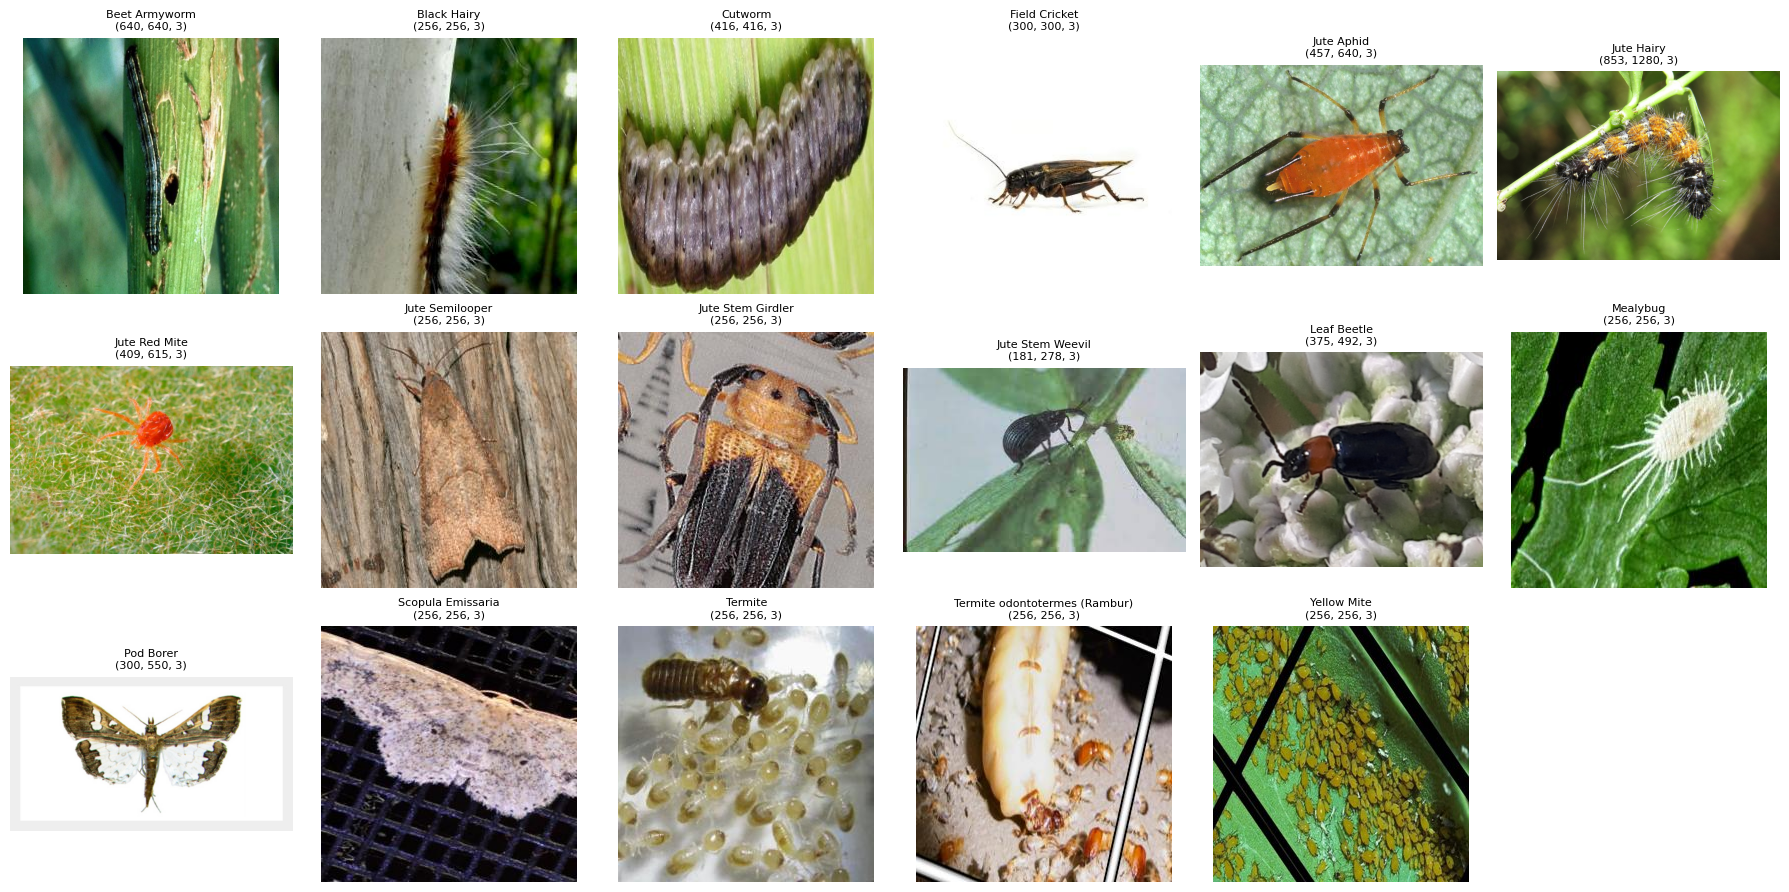

In [4]:
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
axes = axes.flatten()
for i, c in enumerate(classes[:17]):
    imgs = list((train_dir / c).iterdir())
    if imgs:
        img = cv2.imread(str(imgs[0]))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert bgr to rgb for matplotlib
            axes[i].imshow(img)
            axes[i].set_title(f"{c}\n{img.shape}", fontsize=8)
    axes[i].axis('off')
for i in range(len(classes), len(axes)):
    axes[i].axis('off')
plt.tight_layout()
plt.savefig('../results/sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

### Image Preprocessing

Define the image dimensions and batch size for the data generators.

In [5]:
# image dims and batch size; larger bs = higher gpu utilization
h = 224
w = 224
bs = 64  # reduce to 32 if you run out of vram

### Model Architecture

Define the CNN backbone architectures and a function to build transfer learning models with a shared classification head.

In [6]:
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16, DenseNet201

archs = {
    'ResNet50': ResNet50,
    'ResNet101': ResNet101,
    'EfficientNetB0': EfficientNetB0,
    'VGG16': VGG16,
    'DenseNet201': DenseNet201
}
img_shape = (h, w, 3)

def build_model(arch, name, n, dr, l2):
    base = arch(
        weights='imagenet',
        include_top=False,
        input_shape=img_shape
    )
    base.trainable = False
    m = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),  # convert feature maps to feature vector
        layers.BatchNormalization(),
        layers.Dropout(dr),
        layers.Dense(
            256,
            activation='relu',
            kernel_regularizer=regularizers.l2(l2)
        ),
        layers.Dense(
            n,
            activation='softmax',
            kernel_regularizer=regularizers.l2(l2)
        )
    ], name=name)
    return m

m = build_model(ResNet50, 'ResNet50', n_classes, 0.2, 0.01)

### Data Augmentation

Create data generators with augmentation for training and without augmentation for validation and test sets. Visualise sample augmented images to verify the transformations.

In [7]:
def crop_and_contrast_aug(img):
    ratio = np.random.uniform(0.8, 1.0)
    h_img, w_img = img.shape[0], img.shape[1]
    h_new = max(1, int(h_img * ratio))
    w_new = max(1, int(w_img * ratio))
    top = np.random.randint(0, max(1, h_img - h_new + 1))
    left = np.random.randint(0, max(1, w_img - w_new + 1))
    cropped = img[top:top+h_new, left:left+w_new]
    img = cv2.resize(cropped, (w_img, h_img), interpolation=cv2.INTER_LINEAR)

    # contrast adjustment around mean; image in [0, 255] range
    contrast_factor = np.random.uniform(0.8, 1.2)
    mean = np.mean(img, axis=(0, 1), keepdims=True)
    img = (img - mean) * contrast_factor + mean
    img = np.clip(img, 0, 255)  # clip to [0, 255] since rescale happens after

    return img

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    preprocessing_function=crop_and_contrast_aug,
    validation_split=0.2
)

val_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_loader = train_gen.flow_from_directory(
    train_dir,
    target_size=(h, w),
    batch_size=bs,
    class_mode='categorical',
    shuffle=True,
    seed=2003,
    subset='training'
)

val_loader = val_gen.flow_from_directory(
    train_dir,
    target_size=(h, w),
    batch_size=bs,
    class_mode='categorical',
    shuffle=False,
    seed=2003,  # same seed for consistent train/val split
    subset='validation'
)

test_gen = ImageDataGenerator(rescale=1./255)
test_loader = test_gen.flow_from_directory(
    test_dir,
    target_size=(h, w),
    batch_size=bs,
    class_mode='categorical',
    shuffle=False
)

print(f"\nTraining: {train_loader.samples}, Validation: {val_loader.samples}, Test: {test_loader.samples}")


Found 5161 images belonging to 17 classes.
Found 1282 images belonging to 17 classes.
Found 379 images belonging to 17 classes.

Training: 5161, Validation: 1282, Test: 379


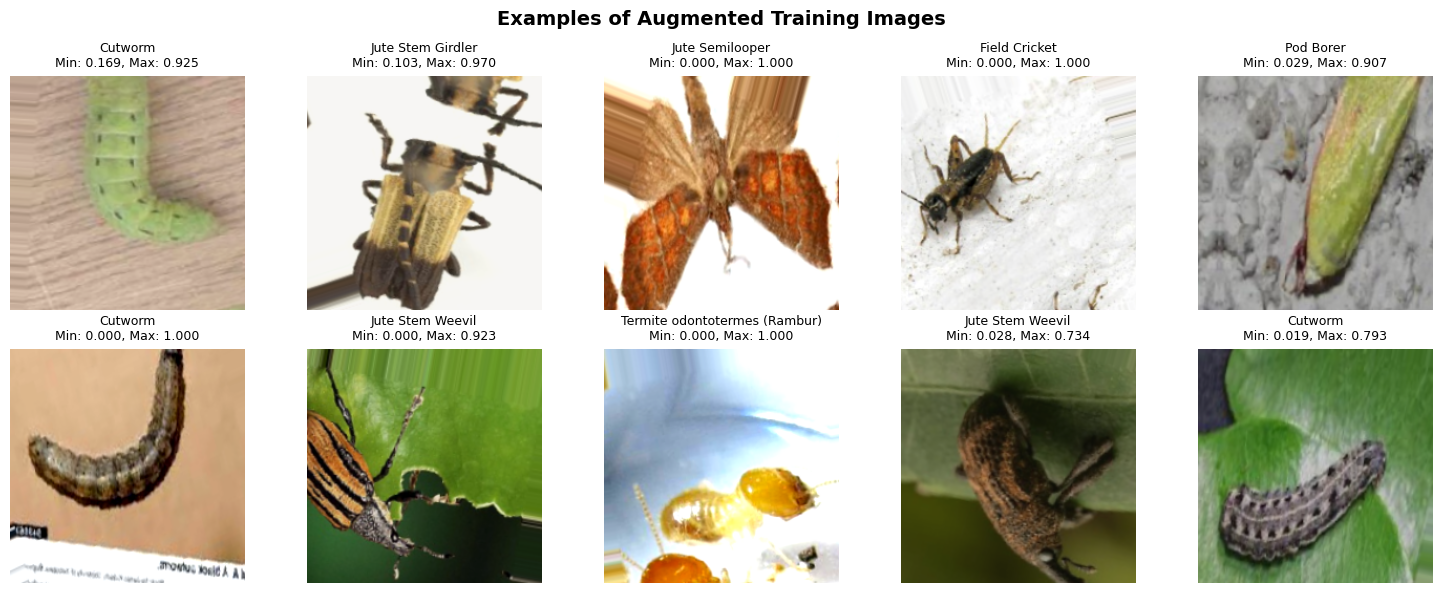

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
imgs = []
labels = []
while len(imgs) < 10:
    x, y = next(train_loader)
    imgs.extend(x)
    labels.extend(y)
    if len(imgs) >= 10:
        break
for i in range(10):
    img = imgs[i].copy()
    img_min, img_max = img.min(), img.max()
    if img_max > 1.0 or img_min < 0.0:
        img = np.clip(img, 0, 1)
    # enhance low-contrast images for display
    if img_max - img_min < 0.1:
        if img_max > img_min:
            img = (img - img_min) / (img_max - img_min)
    if img.dtype != np.float32:
        img = img.astype(np.float32)
    axes[i].imshow(img, vmin=0.0, vmax=1.0)
    idx = np.argmax(labels[i])
    class_name = classes[idx] if idx < len(classes) else f"Class {idx}"
    axes[i].set_title(f"{class_name}\nMin: {img_min:.3f}, Max: {img_max:.3f}", fontsize=9)
    axes[i].axis('off')
plt.suptitle('Examples of Augmented Training Images', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/augmented_images.png', dpi=150, bbox_inches='tight')
plt.show()

# reset train_loader after visualization to ensure all batches are available for training
train_loader.reset()

### Model Configuration

Set the hyperparameters for training: dropout rate, L2 regularisation, learning rate, and number of epochs.

In [9]:
dr = 0.2
l2 = 0.01
lr = 0.001
epochs = 50

def setup(m, lr):
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    if tf.keras.mixed_precision.global_policy().name == 'mixed_float16':
        optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    m.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return m

### Model Training

Define utility functions for compiling models and running training with callbacks (early stopping and model checkpointing).

In [10]:
# re-run this cell if you get eagertensor/json error when training (so fit() uses weights-only checkpoint)
def fit(m, train, val, epochs, name):
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            f'{name}_best.weights.h5',
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True,  # avoids json serialization of eagertensors
            verbose=1
        )
    ]
    print(f"\nTraining {name}...")
    hist = m.fit(
        train,
        epochs=epochs,
        validation_data=val,
        callbacks=callbacks,
        workers=8,
        use_multiprocessing=False,
        max_queue_size=24,
        verbose=1
    )
    return hist

def plot_hist(hist, name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(hist.history['loss'], label='Train Loss', linewidth=2)
    ax1.plot(hist.history['val_loss'], label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title(f'{name} - Loss vs Epochs', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax2.plot(hist.history['accuracy'], label='Train Acc', linewidth=2)
    ax2.plot(hist.history['val_accuracy'], label='Val Acc', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title(f'{name} - Accuracy', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'../results/{name}_training_history.png', dpi=150, bbox_inches='tight')
    plt.show()

### Model Evaluation

Define functions for evaluating model performance (computing metrics) and plotting confusion matrices.

In [11]:
def eval(m, loader, name='Test'):
    print(f"\nEvaluating {name} set...")
    loader.reset()

    # collect predictions batch by batch (handles shuffled loaders)
    all_probs = []
    all_true = []
    steps = len(loader)
    for i in range(steps):
        x_batch, y_batch = next(loader)
        probs_batch = m.predict(x_batch, verbose=0)
        all_probs.append(probs_batch)
        all_true.append(np.argmax(y_batch, axis=1))  # convert one-hot to class indices

    probs = np.vstack(all_probs)
    true = np.concatenate(all_true)
    pred = np.argmax(probs, axis=1)

    # weighted average for class imbalance
    prec = precision_score(true, pred, average='weighted', zero_division=0)
    rec = recall_score(true, pred, average='weighted', zero_division=0)
    f1 = f1_score(true, pred, average='weighted', zero_division=0)
    try:
        true_bin = label_binarize(true, classes=range(n_classes))
        auc = roc_auc_score(true_bin, probs, average='weighted', multi_class='ovr')  # one-vs-rest for multiclass
    except Exception as e:
        print(f"Could not compute AUC: {e}")
        auc = None

    loader.reset()
    loss, acc = m.evaluate(loader, verbose=0)

    metrics = {
        'loss': loss,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'auc': auc
    }
    print(f"\n{name} metrics:")
    print(f"  Loss:      {loss:.4f}")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1:        {f1:.4f}")
    if auc is not None:
        print(f"  AUC:       {auc:.4f}")
    return metrics, true, pred, probs

def plot_cm(true, pred, classes, name, set_name='Test'):
    cm = confusion_matrix(true, pred)
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title(f'{name} - Confusion Matrix ({set_name})', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'../results/{name}_{set_name}_confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()

In [12]:
results = {
    'name': [],
    'train_loss': [], 'train_accuracy': [], 'train_precision': [],
    'train_recall': [], 'train_f1': [], 'train_auc': [],
    'val_loss': [], 'val_accuracy': [], 'val_precision': [],
    'val_recall': [], 'val_f1': [], 'val_auc': [],
    'test_loss': [], 'test_accuracy': [], 'test_precision': [],
    'test_recall': [], 'test_f1': [], 'test_auc': []
}
trained_models = {}
hists = {}

### Train ResNet50

ResNet50 is a 50-layer residual network that uses skip connections to address the vanishing gradient problem. It is a widely used baseline architecture for image classification tasks.


Training ResNet50...
Epoch 1/50
81/81 [==============================] - ETA: 0s - loss: 4.3829 - accuracy: 0.1790
Epoch 1: val_loss improved from inf to 3.72372, saving model to ResNet50_best.weights.h5
81/81 [==============================] - 22s 198ms/step - loss: 4.3829 - accuracy: 0.1790 - val_loss: 3.7237 - val_accuracy: 0.0858
Epoch 2/50
81/81 [==============================] - ETA: 0s - loss: 3.1165 - accuracy: 0.2455
Epoch 2: val_loss improved from 3.72372 to 3.31047, saving model to ResNet50_best.weights.h5
81/81 [==============================] - 18s 207ms/step - loss: 3.1165 - accuracy: 0.2455 - val_loss: 3.3105 - val_accuracy: 0.0905
Epoch 3/50
81/81 [==============================] - ETA: 0s - loss: 2.8570 - accuracy: 0.2513
Epoch 3: val_loss improved from 3.31047 to 3.08278, saving model to ResNet50_best.weights.h5
81/81 [==============================] - 18s 198ms/step - loss: 2.8570 - accuracy: 0.2513 - val_loss: 3.0828 - val_accuracy: 0.1147
Epoch 4/50
81/81 [=======

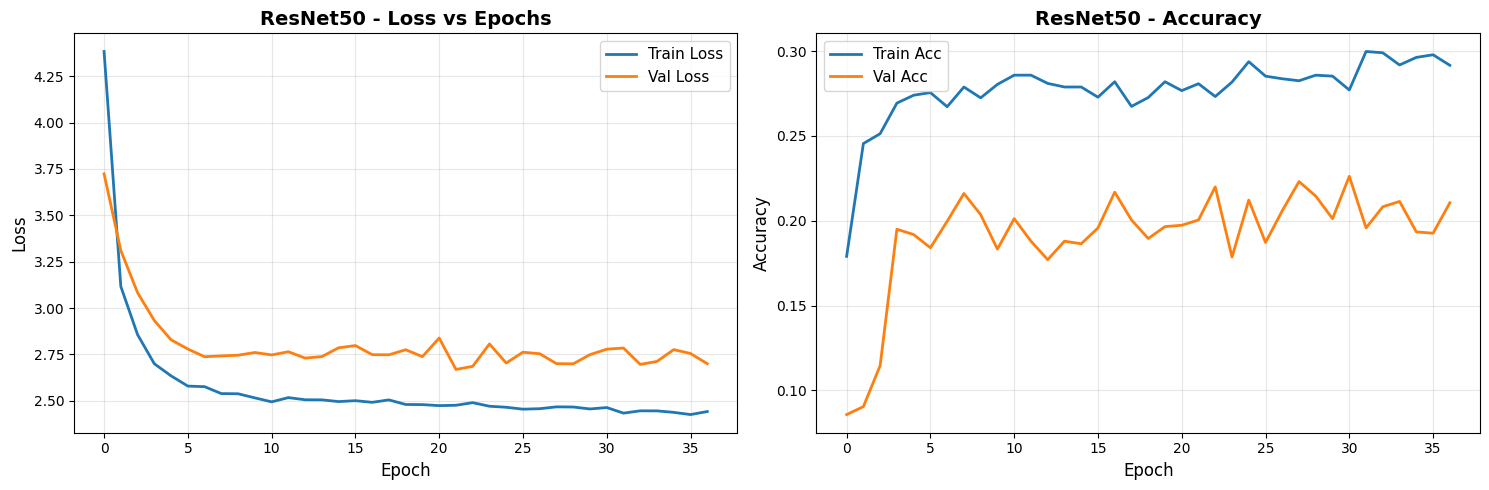


Evaluating Training set...

Training metrics:
  Loss:      2.4201
  Accuracy:  0.3112
  Precision: 0.3151
  Recall:    0.3170
  F1:        0.2987
  AUC:       0.8075

Evaluating Validation set...

Validation metrics:
  Loss:      2.6693
  Accuracy:  0.2005
  Precision: 0.2643
  Recall:    0.2028
  F1:        0.1753
  AUC:       0.7756

Evaluating Test set...

Test metrics:
  Loss:      2.5102
  Accuracy:  0.2533
  Precision: 0.2204
  Recall:    0.2559
  F1:        0.2067
  AUC:       0.8204


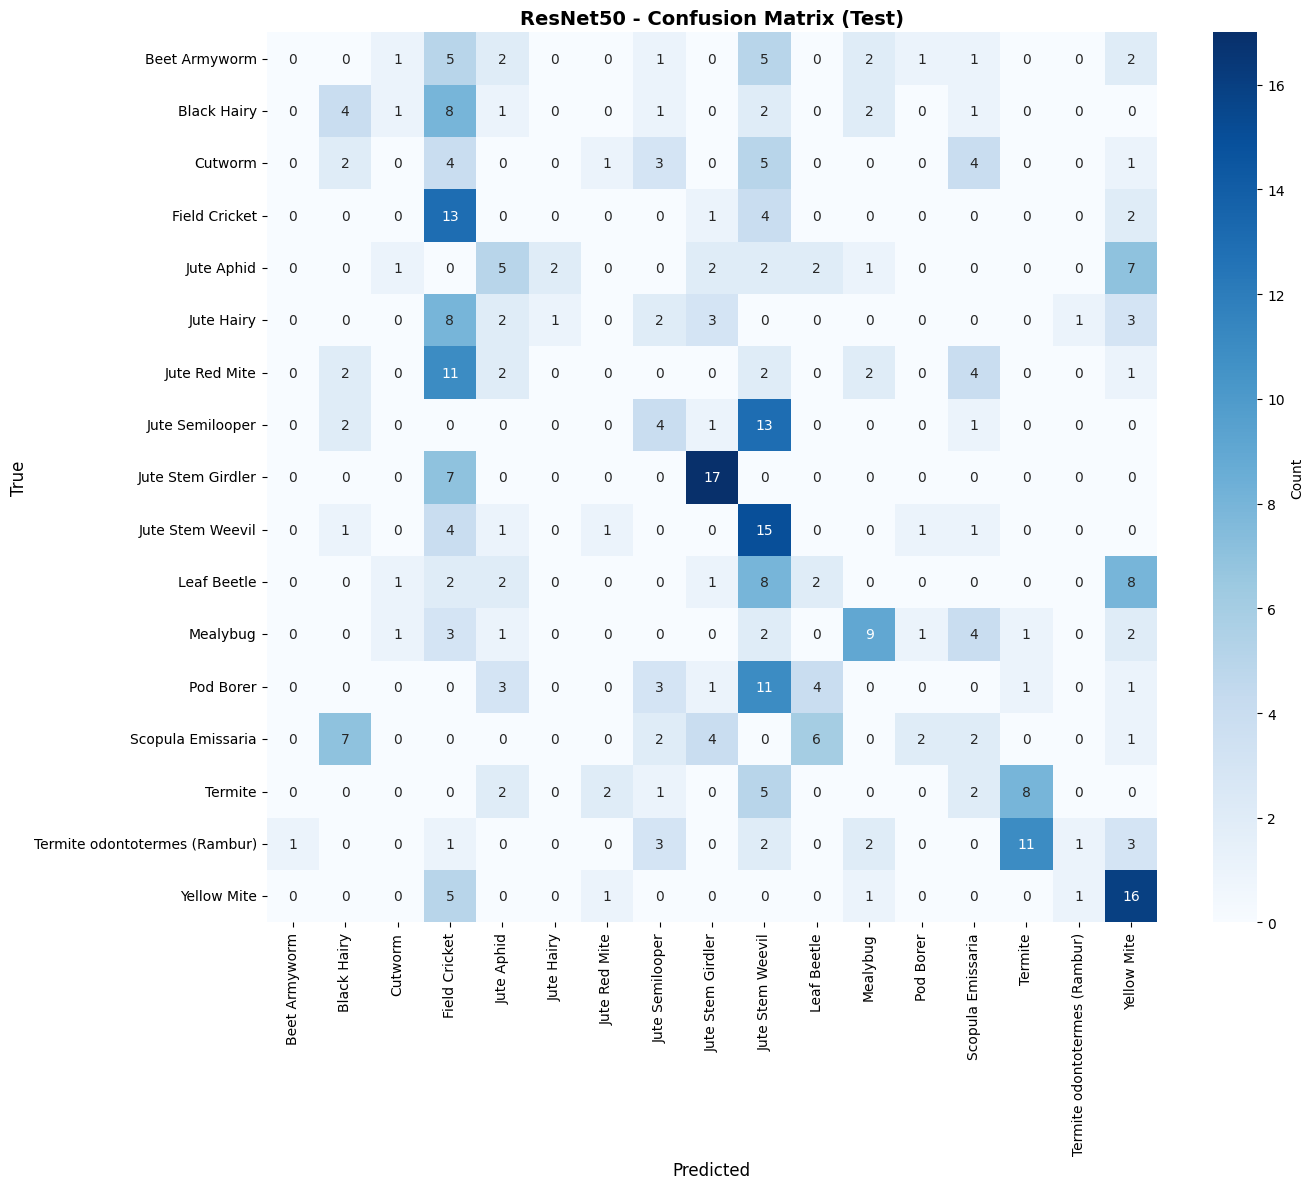

In [13]:
name = 'ResNet50'
m = build_model(
    archs[name],
    name,
    n_classes,
    dr,
    l2
)
m = setup(m, lr)
hist = fit(m, train_loader, val_loader, epochs, name)
plot_hist(hist, name)
train_metrics, _, _, _ = eval(m, train_loader, 'Training')
val_metrics, _, _, _ = eval(m, val_loader, 'Validation')
test_metrics, y_true, y_pred, _ = eval(m, test_loader, 'Test')
plot_cm(y_true, y_pred, classes, name, 'Test')
results['name'].append(name)
for prefix, metrics in [('train', train_metrics), ('val', val_metrics), ('test', test_metrics)]:
    for metric_name, value in metrics.items():
        results[f'{prefix}_{metric_name}'].append(value if value is not None else np.nan)
trained_models[name] = m
hists[name] = hist

### Train ResNet101

ResNet101 is a deeper variant of ResNet with 101 layers. The additional depth can capture more complex features, but may also require more data and careful regularisation to avoid overfitting.


Training ResNet101...
Epoch 1/50
81/81 [==============================] - ETA: 0s - loss: 4.3506 - accuracy: 0.1552
Epoch 1: val_loss improved from inf to 3.69800, saving model to ResNet101_best.weights.h5
81/81 [==============================] - 26s 251ms/step - loss: 4.3506 - accuracy: 0.1552 - val_loss: 3.6980 - val_accuracy: 0.0803
Epoch 2/50
81/81 [==============================] - ETA: 0s - loss: 3.1272 - accuracy: 0.2160
Epoch 2: val_loss improved from 3.69800 to 3.27664, saving model to ResNet101_best.weights.h5
81/81 [==============================] - 19s 214ms/step - loss: 3.1272 - accuracy: 0.2160 - val_loss: 3.2766 - val_accuracy: 0.1225
Epoch 3/50
81/81 [==============================] - ETA: 0s - loss: 2.8852 - accuracy: 0.2195
Epoch 3: val_loss improved from 3.27664 to 3.06428, saving model to ResNet101_best.weights.h5
81/81 [==============================] - 19s 214ms/step - loss: 2.8852 - accuracy: 0.2195 - val_loss: 3.0643 - val_accuracy: 0.1576
Epoch 4/50
81/81 [===

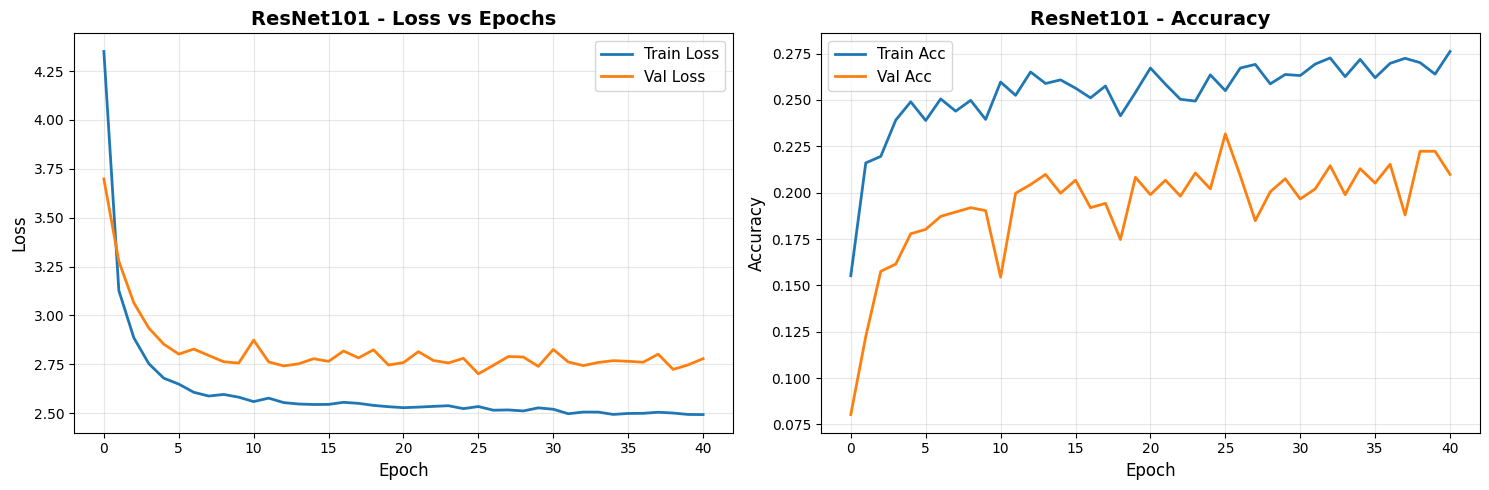


Evaluating Training set...

Training metrics:
  Loss:      2.4907
  Accuracy:  0.2699
  Precision: 0.3080
  Recall:    0.2722
  F1:        0.2522
  AUC:       0.7824

Evaluating Validation set...

Validation metrics:
  Loss:      2.7008
  Accuracy:  0.2317
  Precision: 0.2729
  Recall:    0.2340
  F1:        0.2225
  AUC:       0.7344

Evaluating Test set...

Test metrics:
  Loss:      2.6118
  Accuracy:  0.2507
  Precision: 0.3616
  Recall:    0.2533
  F1:        0.2462
  AUC:       0.7789


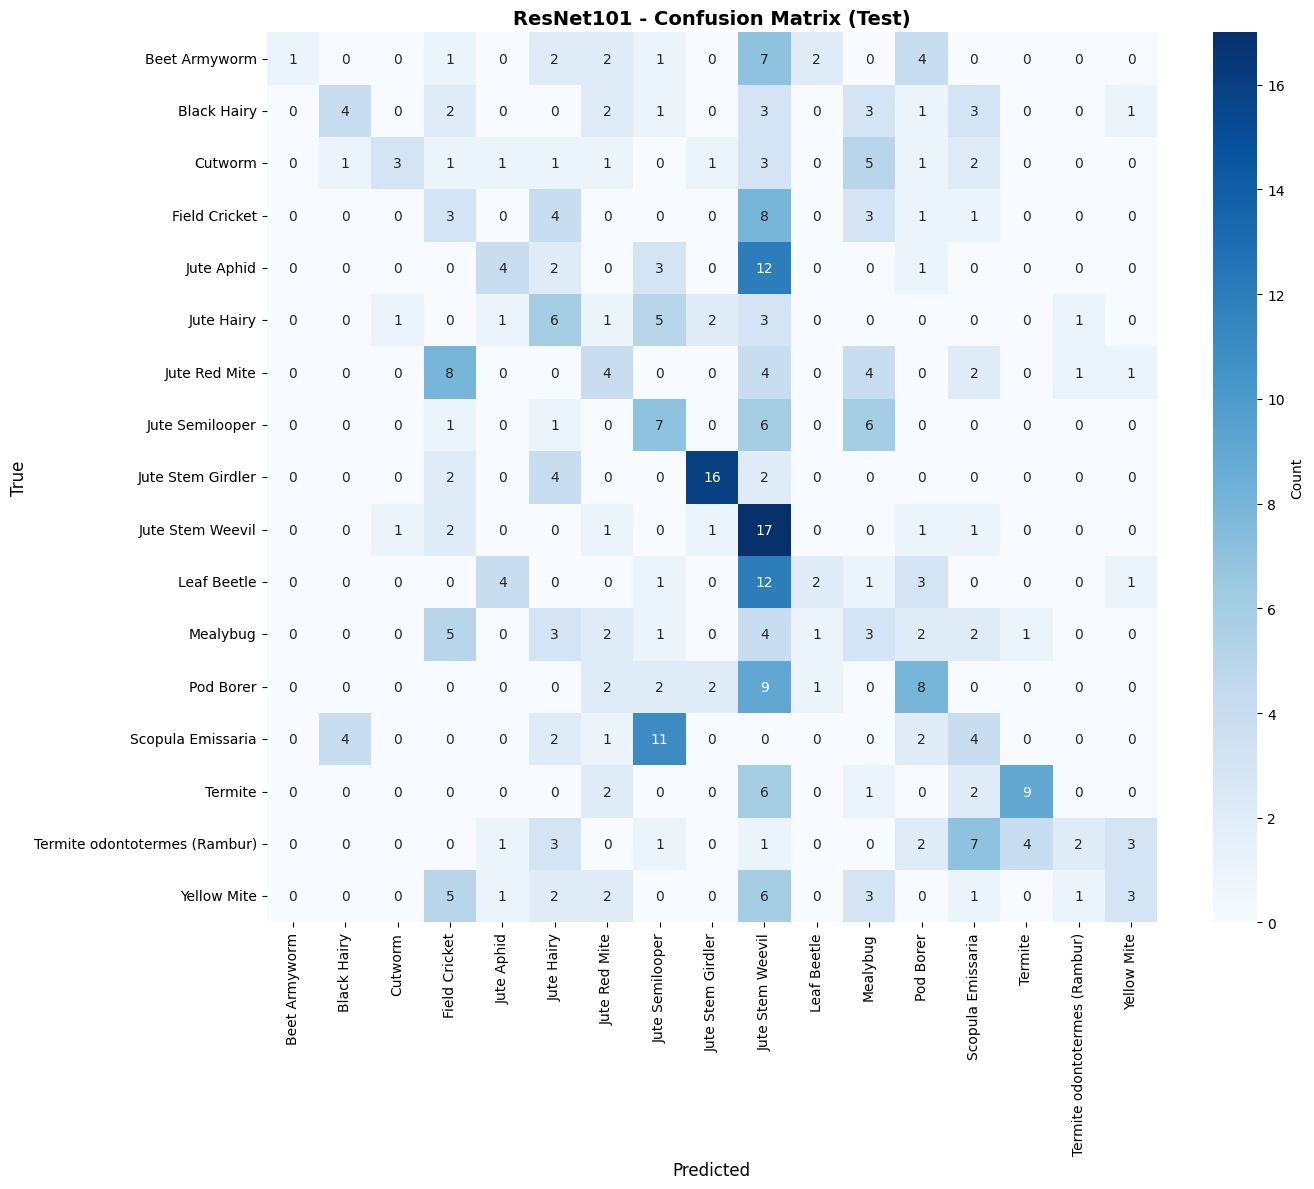

In [14]:
name = 'ResNet101'
m = build_model(
    archs[name], name, n_classes, dr, l2
)
m = setup(m, lr)
hist = fit(m, train_loader, val_loader, epochs, name)
plot_hist(hist, name)
train_metrics, _, _, _ = eval(m, train_loader, 'Training')
val_metrics, _, _, _ = eval(m, val_loader, 'Validation')
test_metrics, y_true, y_pred, _ = eval(m, test_loader, 'Test')
plot_cm(y_true, y_pred, classes, name, 'Test')
results['name'].append(name)
for prefix, metrics in [('train', train_metrics), ('val', val_metrics), ('test', test_metrics)]:
    for metric_name, value in metrics.items():
        results[f'{prefix}_{metric_name}'].append(value if value is not None else np.nan)
trained_models[name] = m
hists[name] = hist

### Train EfficientNetB0

EfficientNetB0 is the baseline model of the EfficientNet family, which uses compound scaling to balance network depth, width, and resolution. It is designed for efficiency while maintaining competitive accuracy.


Training EfficientNetB0...
Epoch 1/50
81/81 [==============================] - ETA: 0s - loss: 6.1909 - accuracy: 0.0787
Epoch 1: val_loss improved from inf to 4.85621, saving model to EfficientNetB0_best.weights.h5
81/81 [==============================] - 23s 212ms/step - loss: 6.1909 - accuracy: 0.0787 - val_loss: 4.8562 - val_accuracy: 0.1053
Epoch 2/50
81/81 [==============================] - ETA: 0s - loss: 4.3247 - accuracy: 0.0872
Epoch 2: val_loss improved from 4.85621 to 3.76330, saving model to EfficientNetB0_best.weights.h5
81/81 [==============================] - 16s 183ms/step - loss: 4.3247 - accuracy: 0.0872 - val_loss: 3.7633 - val_accuracy: 0.1053
Epoch 3/50
81/81 [==============================] - ETA: 0s - loss: 3.5502 - accuracy: 0.0849
Epoch 3: val_loss improved from 3.76330 to 3.30559, saving model to EfficientNetB0_best.weights.h5
81/81 [==============================] - 16s 183ms/step - loss: 3.5502 - accuracy: 0.0849 - val_loss: 3.3056 - val_accuracy: 0.1053
E

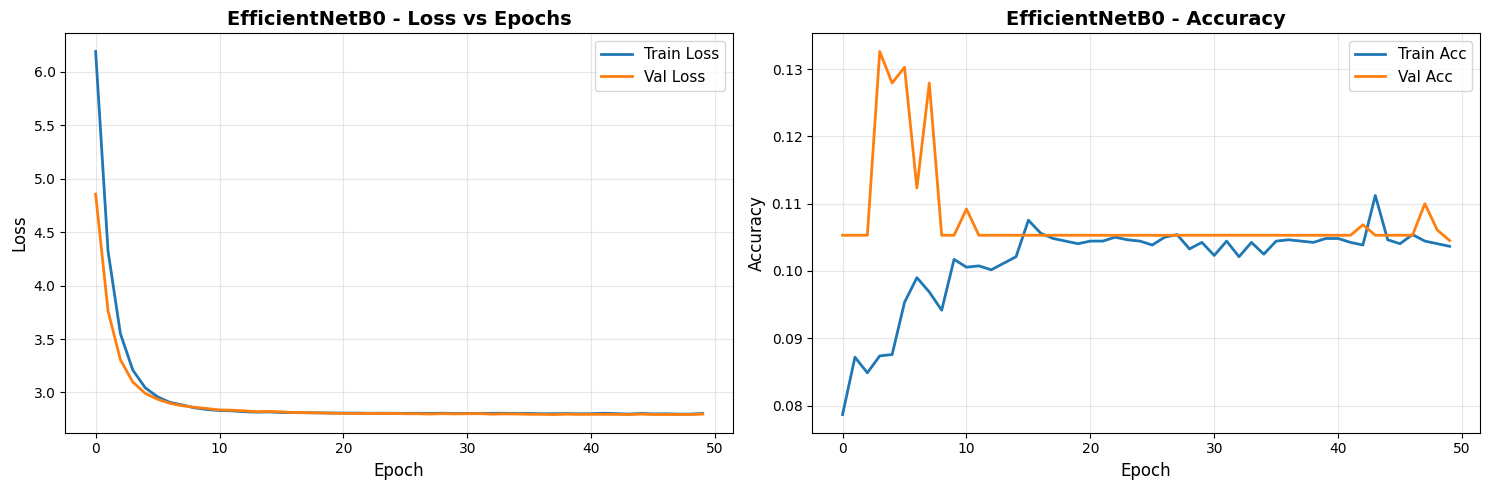


Evaluating Training set...

Training metrics:
  Loss:      2.8042
  Accuracy:  0.1221
  Precision: 0.0217
  Recall:    0.1155
  F1:        0.0365
  AUC:       0.6092

Evaluating Validation set...

Validation metrics:
  Loss:      2.7974
  Accuracy:  0.1045
  Precision: 0.0193
  Recall:    0.1045
  F1:        0.0316
  AUC:       0.5578

Evaluating Test set...

Test metrics:
  Loss:      2.8548
  Accuracy:  0.0844
  Precision: 0.0099
  Recall:    0.0818
  F1:        0.0173
  AUC:       0.5917


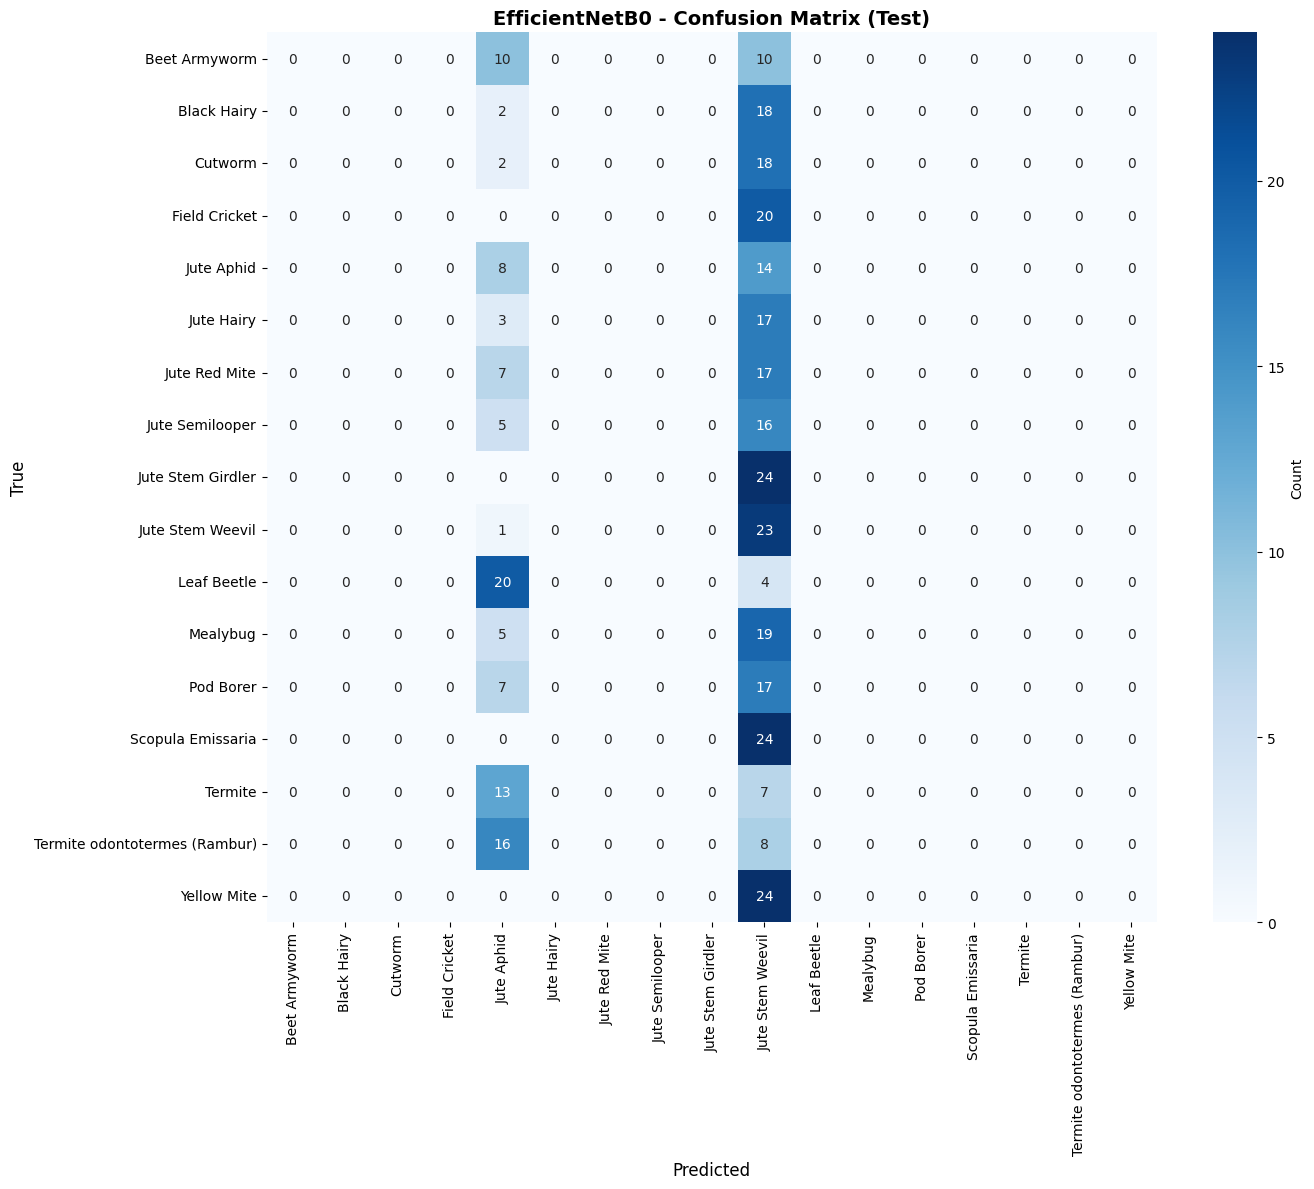

In [15]:
name = 'EfficientNetB0'
m = build_model(
    archs[name], name, n_classes, dr, l2
)
m = setup(m, lr)
hist = fit(m, train_loader, val_loader, epochs, name)
plot_hist(hist, name)
train_metrics, _, _, _ = eval(m, train_loader, 'Training')
val_metrics, _, _, _ = eval(m, val_loader, 'Validation')
test_metrics, y_true, y_pred, _ = eval(m, test_loader, 'Test')
plot_cm(y_true, y_pred, classes, name, 'Test')
results['name'].append(name)
for prefix, metrics in [('train', train_metrics), ('val', val_metrics), ('test', test_metrics)]:
    for metric_name, value in metrics.items():
        results[f'{prefix}_{metric_name}'].append(value if value is not None else np.nan)
trained_models[name] = m
hists[name] = hist

### Train VGG16

VGG16 is a 16-layer network with a simple and uniform architecture using 3x3 convolution filters throughout. Despite being older, it remains a strong baseline due to its simplicity and the quality of its learned features.


Training VGG16...
Epoch 1/50
81/81 [==============================] - ETA: 0s - loss: 4.6149 - accuracy: 0.4943
Epoch 1: val_loss improved from inf to 4.61087, saving model to VGG16_best.weights.h5
81/81 [==============================] - 18s 187ms/step - loss: 4.6149 - accuracy: 0.4943 - val_loss: 4.6109 - val_accuracy: 0.2785
Epoch 2/50
81/81 [==============================] - ETA: 0s - loss: 2.8232 - accuracy: 0.7014
Epoch 2: val_loss improved from 4.61087 to 3.43952, saving model to VGG16_best.weights.h5
81/81 [==============================] - 17s 186ms/step - loss: 2.8232 - accuracy: 0.7014 - val_loss: 3.4395 - val_accuracy: 0.5328
Epoch 3/50
81/81 [==============================] - ETA: 0s - loss: 2.0727 - accuracy: 0.7599
Epoch 3: val_loss improved from 3.43952 to 2.68921, saving model to VGG16_best.weights.h5
81/81 [==============================] - 17s 185ms/step - loss: 2.0727 - accuracy: 0.7599 - val_loss: 2.6892 - val_accuracy: 0.6217
Epoch 4/50
81/81 [===================

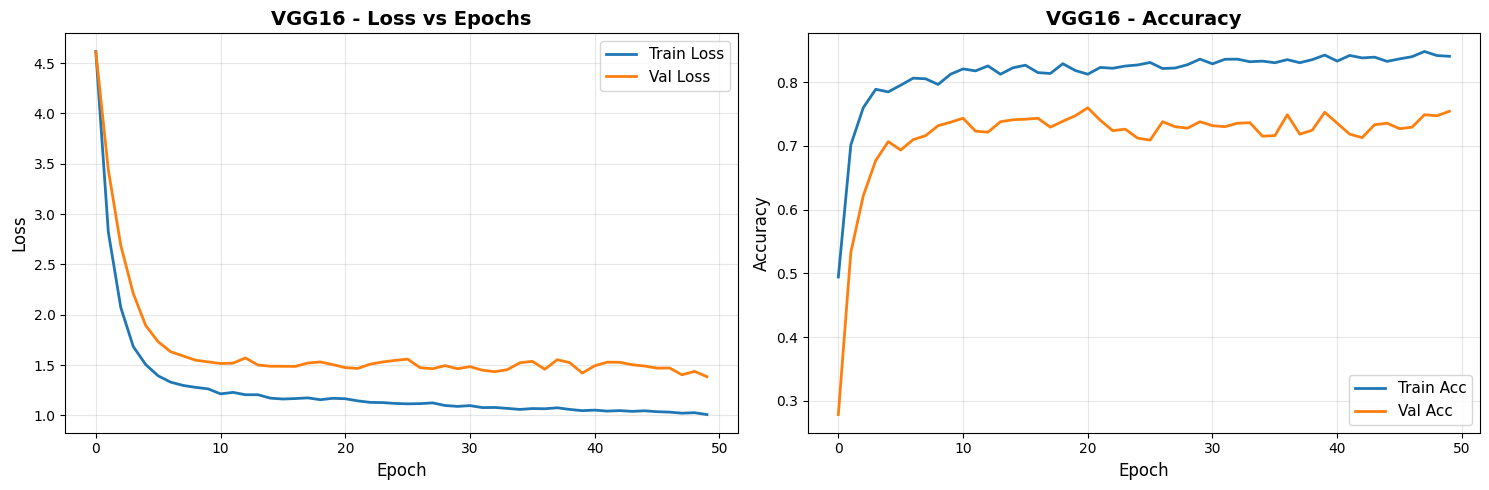


Evaluating Training set...

Training metrics:
  Loss:      0.8937
  Accuracy:  0.8929
  Precision: 0.8928
  Recall:    0.8890
  F1:        0.8872
  AUC:       0.9942

Evaluating Validation set...

Validation metrics:
  Loss:      1.3848
  Accuracy:  0.7543
  Precision: 0.7674
  Recall:    0.7543
  F1:        0.7472
  AUC:       0.9654

Evaluating Test set...

Test metrics:
  Loss:      1.0586
  Accuracy:  0.8311
  Precision: 0.8540
  Recall:    0.8311
  F1:        0.8200
  AUC:       0.9862


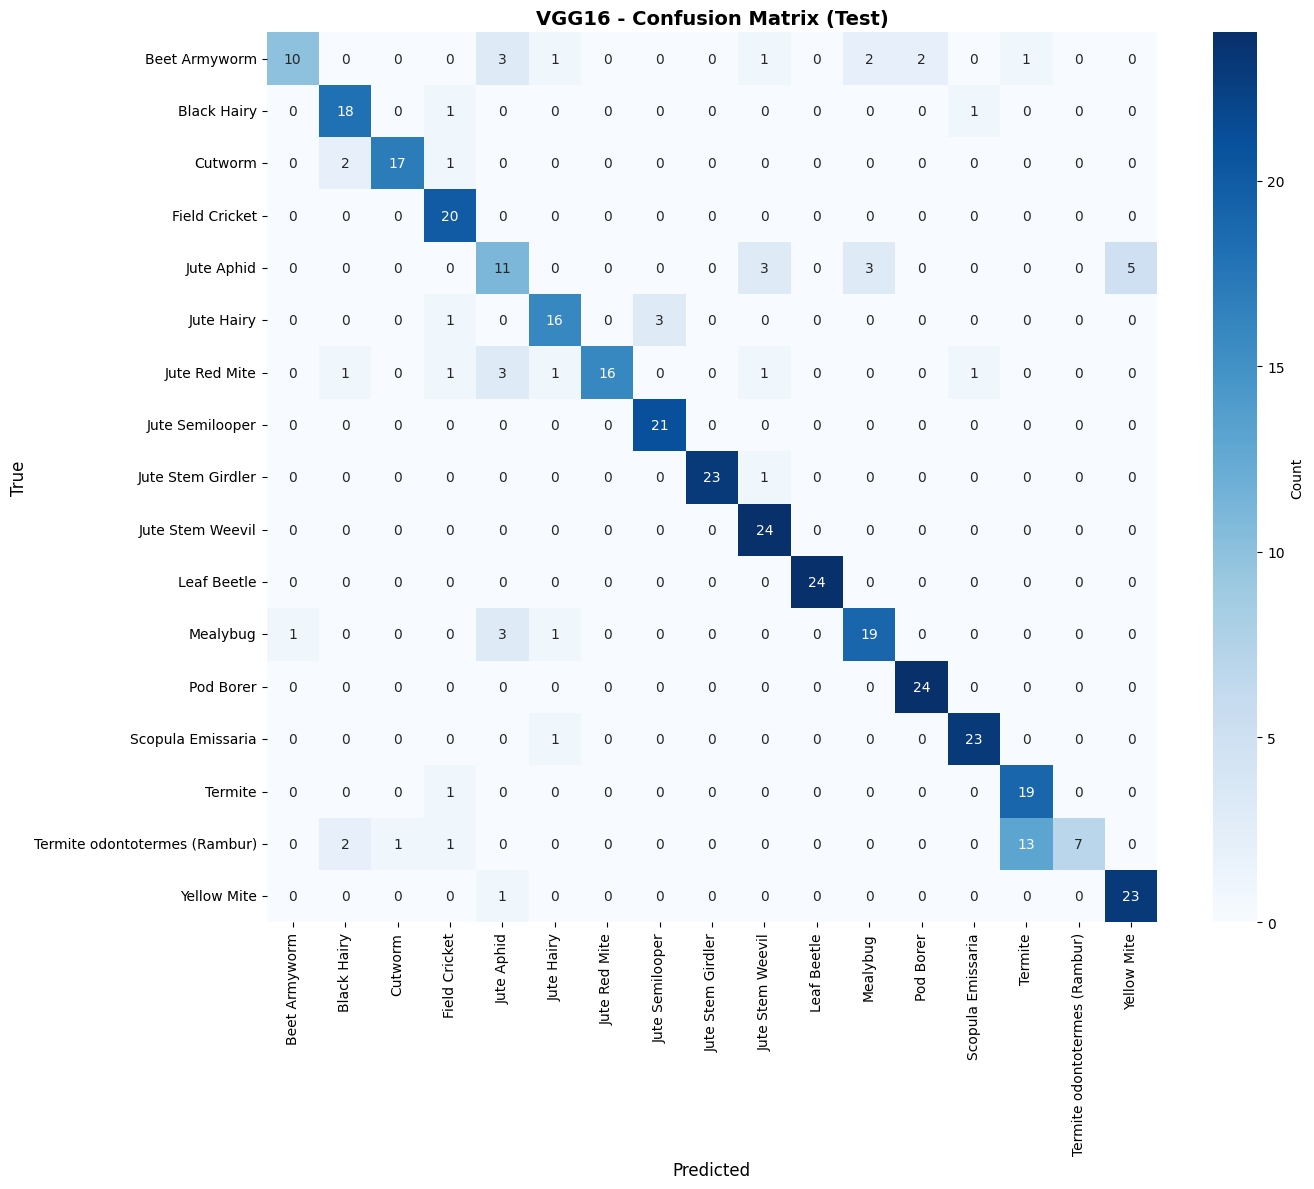

In [16]:
name = 'VGG16'
m = build_model(
    archs[name], name, n_classes, dr, l2
)
m = setup(m, lr)
hist = fit(m, train_loader, val_loader, epochs, name)
plot_hist(hist, name)
train_metrics, _, _, _ = eval(m, train_loader, 'Training')
val_metrics, _, _, _ = eval(m, val_loader, 'Validation')
test_metrics, y_true, y_pred, _ = eval(m, test_loader, 'Test')
plot_cm(y_true, y_pred, classes, name, 'Test')
results['name'].append(name)
for prefix, metrics in [('train', train_metrics), ('val', val_metrics), ('test', test_metrics)]:
    for metric_name, value in metrics.items():
        results[f'{prefix}_{metric_name}'].append(value if value is not None else np.nan)
trained_models[name] = m
hists[name] = hist

### Train DenseNet201

DenseNet201 uses dense connectivity where each layer receives feature maps from all preceding layers. This promotes feature reuse, improves gradient flow, and can be particularly effective for fine-grained classification tasks.


Training DenseNet201...
Epoch 1/50
81/81 [==============================] - ETA: 0s - loss: 3.3932 - accuracy: 0.7485
Epoch 1: val_loss improved from inf to 2.33635, saving model to DenseNet201_best.weights.h5
81/81 [==============================] - 31s 268ms/step - loss: 3.3932 - accuracy: 0.7485 - val_loss: 2.3363 - val_accuracy: 0.8214
Epoch 2/50
81/81 [==============================] - ETA: 0s - loss: 1.6386 - accuracy: 0.9126
Epoch 2: val_loss improved from 2.33635 to 1.52158, saving model to DenseNet201_best.weights.h5
81/81 [==============================] - 19s 214ms/step - loss: 1.6386 - accuracy: 0.9126 - val_loss: 1.5216 - val_accuracy: 0.8768
Epoch 3/50
81/81 [==============================] - ETA: 0s - loss: 1.1075 - accuracy: 0.9332
Epoch 3: val_loss improved from 1.52158 to 1.15852, saving model to DenseNet201_best.weights.h5
81/81 [==============================] - 19s 215ms/step - loss: 1.1075 - accuracy: 0.9332 - val_loss: 1.1585 - val_accuracy: 0.8752
Epoch 4/50
81

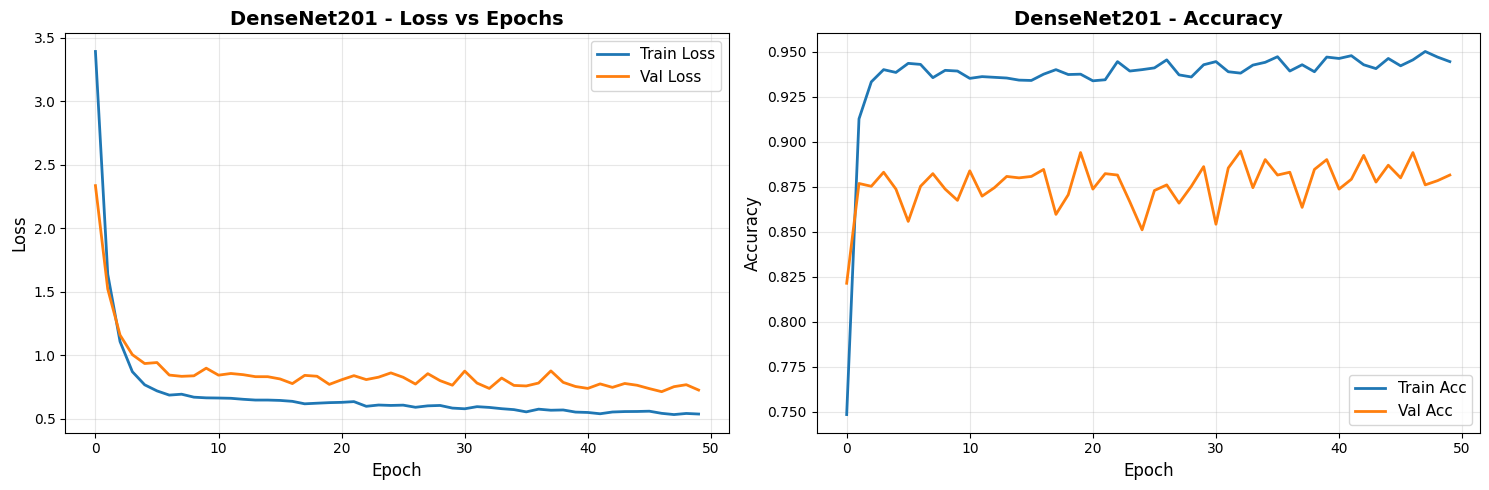


Evaluating Training set...

Training metrics:
  Loss:      0.4772
  Accuracy:  0.9674
  Precision: 0.9697
  Recall:    0.9692
  F1:        0.9690
  AUC:       0.9994

Evaluating Validation set...

Validation metrics:
  Loss:      0.7257
  Accuracy:  0.8814
  Precision: 0.8893
  Recall:    0.8814
  F1:        0.8819
  AUC:       0.9927

Evaluating Test set...

Test metrics:
  Loss:      0.4870
  Accuracy:  0.9657
  Precision: 0.9684
  Recall:    0.9657
  F1:        0.9659
  AUC:       0.9990


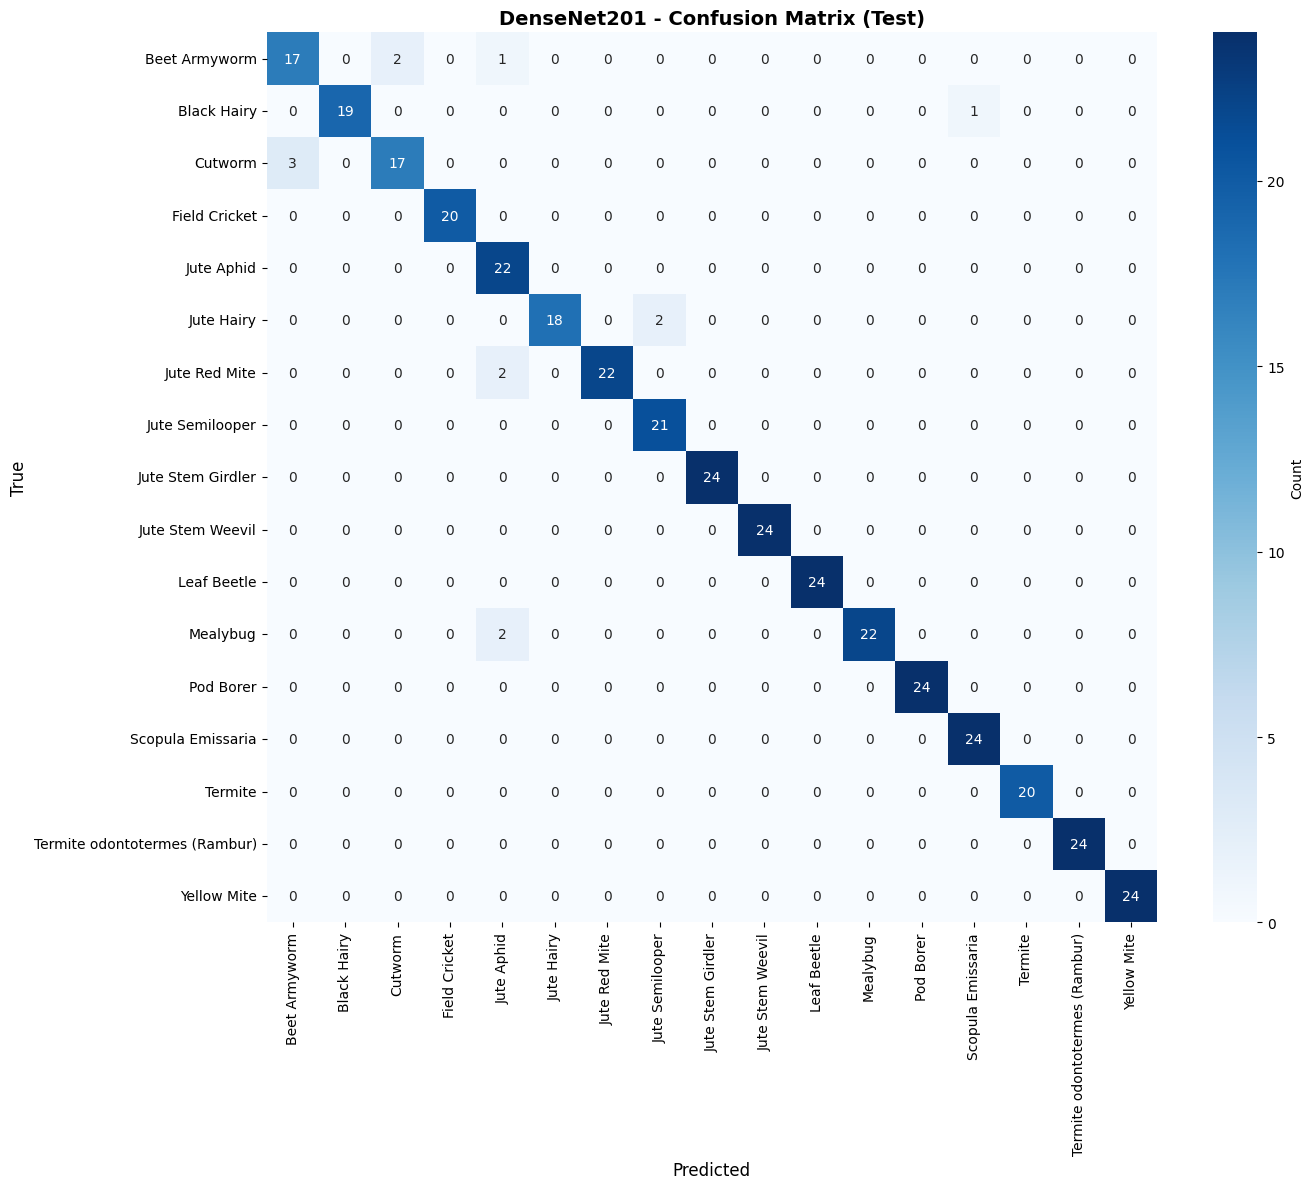

In [17]:
name = 'DenseNet201'
m = build_model(
    archs[name], name, n_classes, dr, l2
)
m = setup(m, lr)
hist = fit(m, train_loader, val_loader, epochs, name)
plot_hist(hist, name)
train_metrics, _, _, _ = eval(m, train_loader, 'Training')
val_metrics, _, _, _ = eval(m, val_loader, 'Validation')
test_metrics, y_true, y_pred, _ = eval(m, test_loader, 'Test')
plot_cm(y_true, y_pred, classes, name, 'Test')
results['name'].append(name)
for prefix, metrics in [('train', train_metrics), ('val', val_metrics), ('test', test_metrics)]:
    for metric_name, value in metrics.items():
        results[f'{prefix}_{metric_name}'].append(value if value is not None else np.nan)
trained_models[name] = m
hists[name] = hist

### Model Comparison and Results

Compile all model metrics into a table and save the results for analysis.

In [18]:
df = pd.DataFrame(results)
print("\nModel Comparison Results:")
print(df.to_string(index=False))
df.to_csv('../results/model_comparison_results.csv', index=False)



Model Comparison Results:
          name  train_loss  train_accuracy  train_precision  train_recall  train_f1  train_auc  val_loss  val_accuracy  val_precision  val_recall   val_f1  val_auc  test_loss  test_accuracy  test_precision  test_recall  test_f1  test_auc
      ResNet50    2.420054        0.311180         0.315060      0.316993  0.298694   0.807539  2.669282      0.200468       0.264260    0.202808 0.175280 0.775643   2.510200       0.253298        0.220407     0.255937 0.206710  0.820373
     ResNet101    2.490749        0.269909         0.308043      0.272234  0.252246   0.782404  2.700799      0.231669       0.272907    0.234009 0.222473 0.734384   2.611776       0.250660        0.361628     0.253298 0.246187  0.778909
EfficientNetB0    2.804182        0.122069         0.021724      0.115481  0.036543   0.609177  2.797441      0.104524       0.019252    0.104524 0.031609 0.557786   2.854836       0.084433        0.009892     0.081794 0.017258  0.591664
         VGG16    0.8

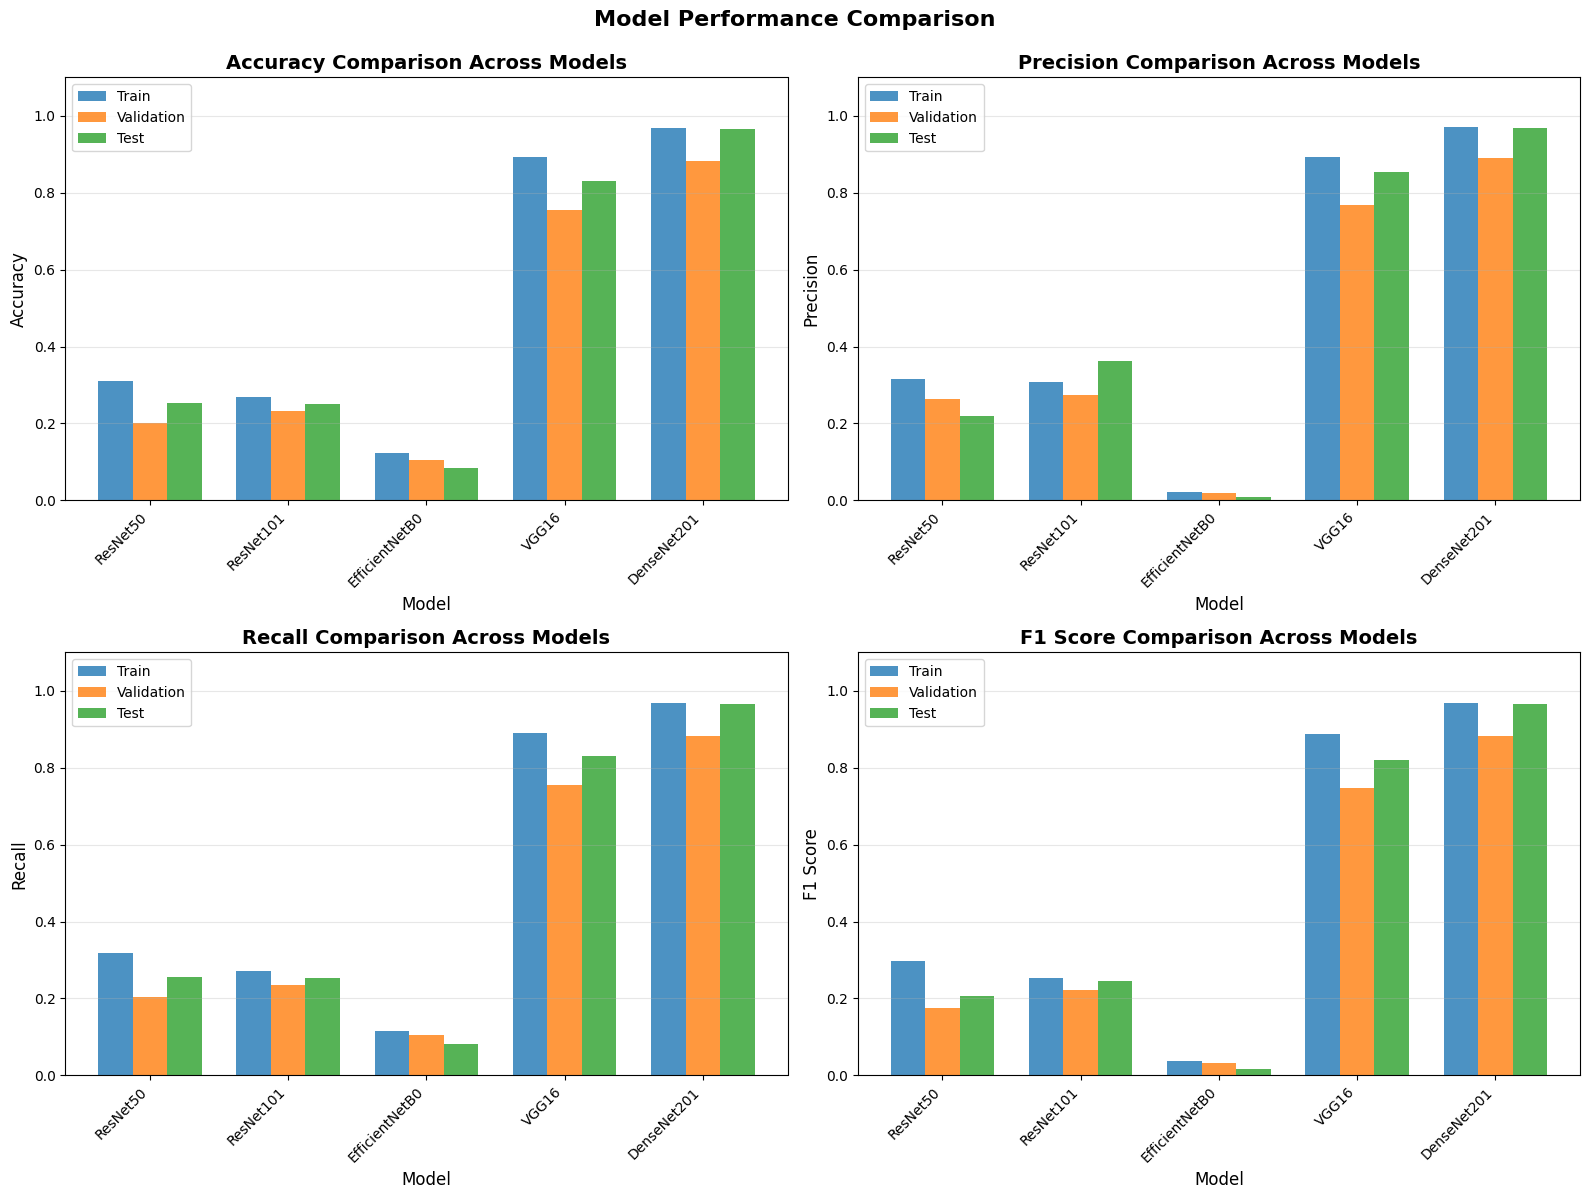

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
for idx, (metric, label) in enumerate(zip(metrics_to_plot, metric_labels)):
    ax = axes[idx // 2, idx % 2]
    x = np.arange(len(df))
    width = 0.25
    train_vals = df[f'train_{metric}'].values
    val_vals = df[f'val_{metric}'].values
    test_vals = df[f'test_{metric}'].values
    ax.bar(x - width, train_vals, width, label='Train', alpha=0.8)
    ax.bar(x, val_vals, width, label='Validation', alpha=0.8)
    ax.bar(x + width, test_vals, width, label='Test', alpha=0.8)
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel(label, fontsize=12)
    ax.set_title(f'{label} Comparison Across Models', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(df['name'].values, rotation=45, ha='right')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1.1])
plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../results/all_models_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
best_idx = df['test_f1'].idxmax()
best_name = df.loc[best_idx, 'name']
print(f"\nBest Model: {best_name}")
print(f"Test - Accuracy: {df.loc[best_idx, 'test_accuracy']:.4f}, Precision: {df.loc[best_idx, 'test_precision']:.4f}, Recall: {df.loc[best_idx, 'test_recall']:.4f}, F1: {df.loc[best_idx, 'test_f1']:.4f}, AUC: {df.loc[best_idx, 'test_auc']:.4f}")
print("\nModel Rankings by Test F1 Score:")
ranking = df[['name', 'test_f1']].sort_values('test_f1', ascending=False)
for idx, (_, row) in enumerate(ranking.iterrows(), 1):
    print(f"  {idx}. {row['name']}: {row['test_f1']:.4f}")


Best Model: DenseNet201
Test - Accuracy: 0.9657, Precision: 0.9684, Recall: 0.9657, F1: 0.9659, AUC: 0.9990

Model Rankings by Test F1 Score:
  1. DenseNet201: 0.9659
  2. VGG16: 0.8200
  3. ResNet101: 0.2462
  4. ResNet50: 0.2067
  5. EfficientNetB0: 0.0173


### Model Performance Analysis

The table above reports training, validation, and test metrics (Precision, Recall, AUC, and F1 scores) for all models.

**Evaluation methodology:**
- This is a multi-class classification problem with **17 classes**
- **Weighted averaging** was used for Precision, Recall, and F1 to handle class imbalance
- **AUC** was computed using the one-vs-rest strategy for the multi-class setting

The best performing model is identified based on test F1 score rankings. A model clearly outperforms others if it ranks first across multiple metrics with a substantial gap (>2-3%) over the second-best model.

## Results

From the final `results/model_comparison_results.csv` file, the models behave as follows on the **test set**:

| Model | Test Accuracy | Test F1 | Test AUC |
|-------|--------------|---------|----------|
| **DenseNet201** | **96.6%** | **0.966** | **0.999** |
| VGG16 | 83.1% | 0.820 | 0.986 |
| ResNet50 | 25.3% | 0.207 | 0.820 |
| ResNet101 | 25.1% | 0.246 | 0.779 |
| EfficientNetB0 | 8.4% | 0.017 | 0.592 |

### Key Observations

**DenseNet201** achieves the best performance across all metrics by a significant margin. Its dense connectivity pattern promotes feature reuse at multiple scales, which appears particularly effective for distinguishing fine-grained differences between pest species. The near-perfect AUC (0.999) indicates excellent discriminative ability across all 17 classes.

**VGG16** serves as a strong second-best model, achieving 83% accuracy. Its simpler architecture with uniform 3x3 convolutions produces stable, well-generalised features that transfer effectively to this domain.

**ResNet50 and ResNet101** underperform significantly under this training setup. This may be due to the batch normalisation layers in ResNet requiring careful handling during transfer learning, or the learning rate being suboptimal for these architectures. Fine-tuning the base layers (rather than freezing them entirely) might improve results.

**EfficientNetB0** performs poorly, likely because it expects a specific input preprocessing pipeline (different normalisation scheme) that was not applied here. The architecture also uses mobile inverted bottleneck convolutions which may require more careful fine-tuning.

### Confusion Matrix Analysis

The confusion matrices reveal that misclassifications typically occur between:
- Visually similar species (e.g., pests with similar colouration or body shape)
- Classes with fewer training examples, where the model has less data to learn distinguishing features

## Limitations

Despite strong quantitative results (especially with DenseNet201), there are several important limitations:

1. **Dataset bias**: The models are trained and evaluated on a specific curated dataset; real-world field images may differ significantly in quality, lighting, background complexity, and pest appearance.

2. **Class imbalance**: Some pest classes are under-represented, which can hurt per-class performance even when using weighted metrics. The model may perform poorly on rare but economically important pests.

3. **Model size**: DenseNet201 has approximately 20 million parameters, which may hinder deployment on low-resource devices such as entry-level smartphones commonly used in agricultural settings.

4. **Single training configuration**: All models used identical hyperparameters, which may not be optimal for each architecture. Architecture-specific tuning could improve results, particularly for ResNet and EfficientNet.

## Future Work

Potential directions for extending and improving this work include:

- **Data expansion**: Collect more diverse images from different fields, seasons, and imaging conditions to better match real-world variability.

- **Per-class error analysis**: Perform detailed analysis of misclassified samples and design targeted augmentation strategies for frequently confused classes.

- **Architecture-specific tuning**: Experiment with different learning rates, preprocessing pipelines, and fine-tuning strategies tailored to each architecture.

- **Model compression**: Explore MobileNet, EfficientNet-Lite, pruning, and quantisation to build models suitable for on-device deployment without significant accuracy loss.

- **Explainability**: Apply methods like Grad-CAM to visualise which image regions drive the model's predictions, helping agronomists trust and interpret model outputs.

- **Practical deployment**: Wrap the best-performing model into a prototype mobile application that farmers and agronomists can use in the field for real-time pest identification.

## Conclusion

This project demonstrates that **transfer learning with DenseNet201** is highly effective for jute pest classification, achieving 96.6% accuracy on the test set with 17 pest classes. The dense connectivity architecture proves particularly well-suited for distinguishing fine-grained visual differences between pest species.

The significant performance gap between DenseNet201/VGG16 and the other architectures highlights the importance of matching the training configuration to each architecture's requirements. While the current results establish a strong baseline, there is considerable room for improvement through architecture-specific tuning and expanded training data.

Automated pest identification systems like this have the potential to support timely intervention, reduce pesticide misuse, and improve crop yields for jute farmers. The next steps involve optimising the model for mobile deployment and conducting field trials to validate real-world performance.